In [1]:
import gzip
import os
from pathlib import Path
import pickle
import subprocess
from shutil import rmtree
from tempfile import mkdtemp

In [2]:
neuroquery_data_dir = Path("/fast/work/groups/ag_walter/newdata/neuroquery")
neuroquery_data_dir.mkdir(exist_ok=True, parents=True)
os.environ["NEUROQUERY_DATA_DIR"] = str(neuroquery_data_dir)

In [3]:
from halfpipe.utils.format import format_like_bids
from matplotlib import pyplot as plt
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, view_img
import numpy as np
import pandas as pd
from scipy.ndimage import center_of_mass
from scipy.stats import norm
import svgutils.transform as sg
from templateflow.api import get

In [4]:
from neuroquery import fetch_neuroquery_model, NeuroQueryModel

encoder = NeuroQueryModel.from_data_dir(fetch_neuroquery_model())

/fast/work/users/wallerl_c/miniforge3/envs/gpu/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [5]:
template_path = get(template="MNI152NLin2009cAsym", resolution=2, desc="brain", suffix="T1w")
template_image = nib.load(template_path)

template_mask_path = get(template="MNI152NLin2009cAsym", resolution=2, desc="brain", suffix="mask")
template_mask_image = nib.load(template_mask_path)
template_mask_data = np.asanyarray(template_mask_image.dataobj, dtype=bool)

In [6]:
posterior_map_image = nib.Nifti1Image.from_filename("probability.nii.gz")


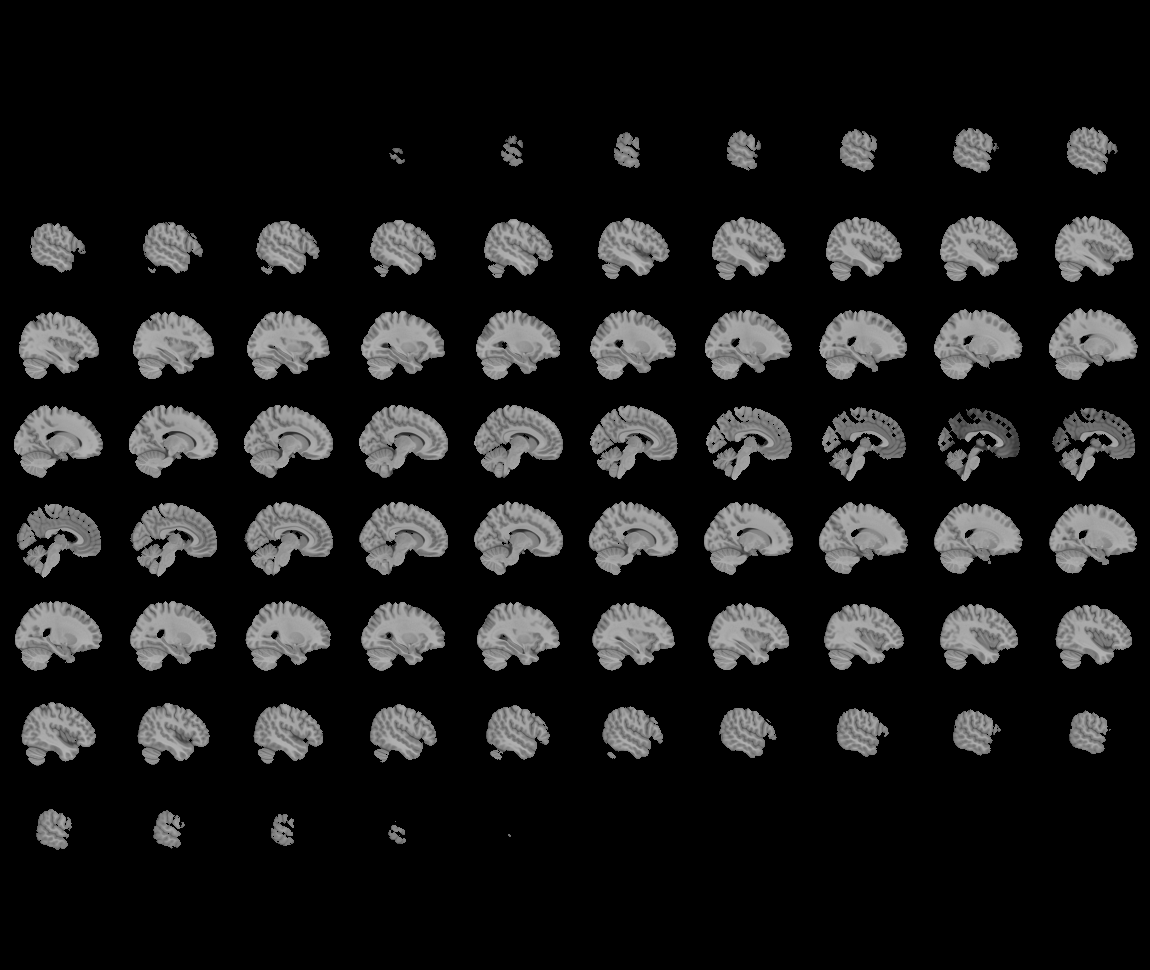
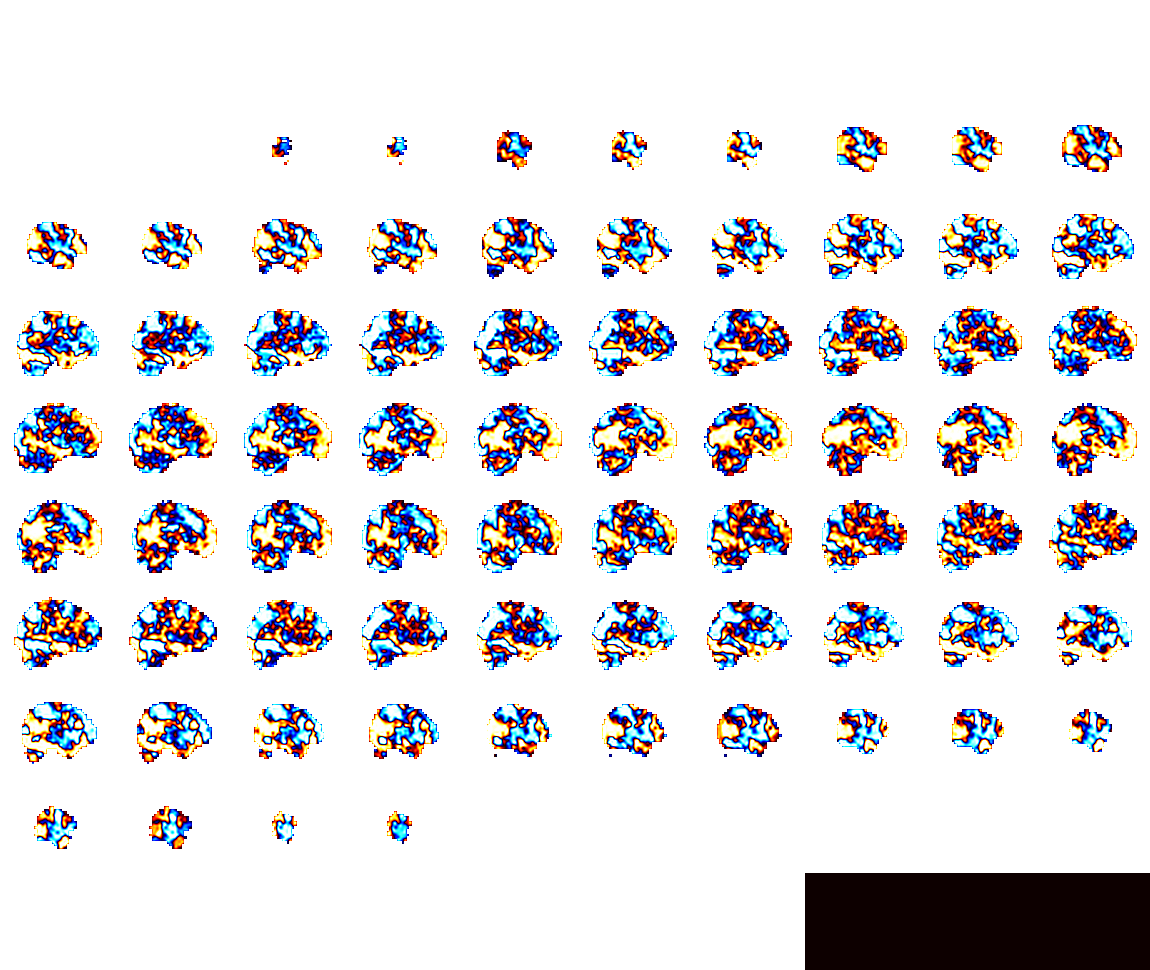

In [7]:
view_img(posterior_map_image, template_image)

In [8]:
base_path = Path.cwd()

In [9]:
def encode(term):
    map_path = base_path / f"term-{format_like_bids(term)}_tpl-MNI152NLin6Asym_statmap.nii.gz"
    resampled_map_path = base_path / f"term-{format_like_bids(term)}_tpl-MNI152NLin2009cAsym_statmap.nii.gz"
    
    if not map_path.is_file():
        map_image = encoder(term)["brain_map"]
        nib.save(map_image, filename=map_path)
    
    if not resampled_map_path.is_file():
        subprocess.call([
            "singularity", 
            "exec",
            "--contain", 
            "--cleanenv", 
            "--bind", 
            "/fast:/fast", 
            "/fast/work/users/wallerl_c/containers/halfpipe-halfpipe-latest.sif", 
            "antsApplyTransforms", 
            "--dimensionality", 
            "3",
            "--input", 
            map_path, 
            "--reference-image", 
            "/home/fmriprep/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_T1w.nii.gz", 
            "--output", 
            resampled_map_path, 
            "--interpolation", 
            "LanczosWindowedSinc", 
            "--transform", 
            "/home/fmriprep/.cache/halfpipe/tpl_MNI152NLin2009cAsym_from_MNI152NLin6Asym_mode_image_xfm.h5", 
        ])
    
    resampled_map_image = nib.load(resampled_map_path)
    return resampled_map_image

In [10]:
neuroquery_map_image = encode("faces")
neuroquery_map_data = neuroquery_map_image.get_fdata()

levels = np.quantile(neuroquery_map_data, [0.99, 0.995, 0.999])

voxel_index = neuroquery_map_data.argmax()
voxel_coordinate = np.unravel_index(voxel_index, neuroquery_map_image.shape)
mni_coordinate = nib.affines.apply_affine(neuroquery_map_image.affine, voxel_coordinate)

print(mni_coordinate)

[ 39.5 -56.5 -24.5]


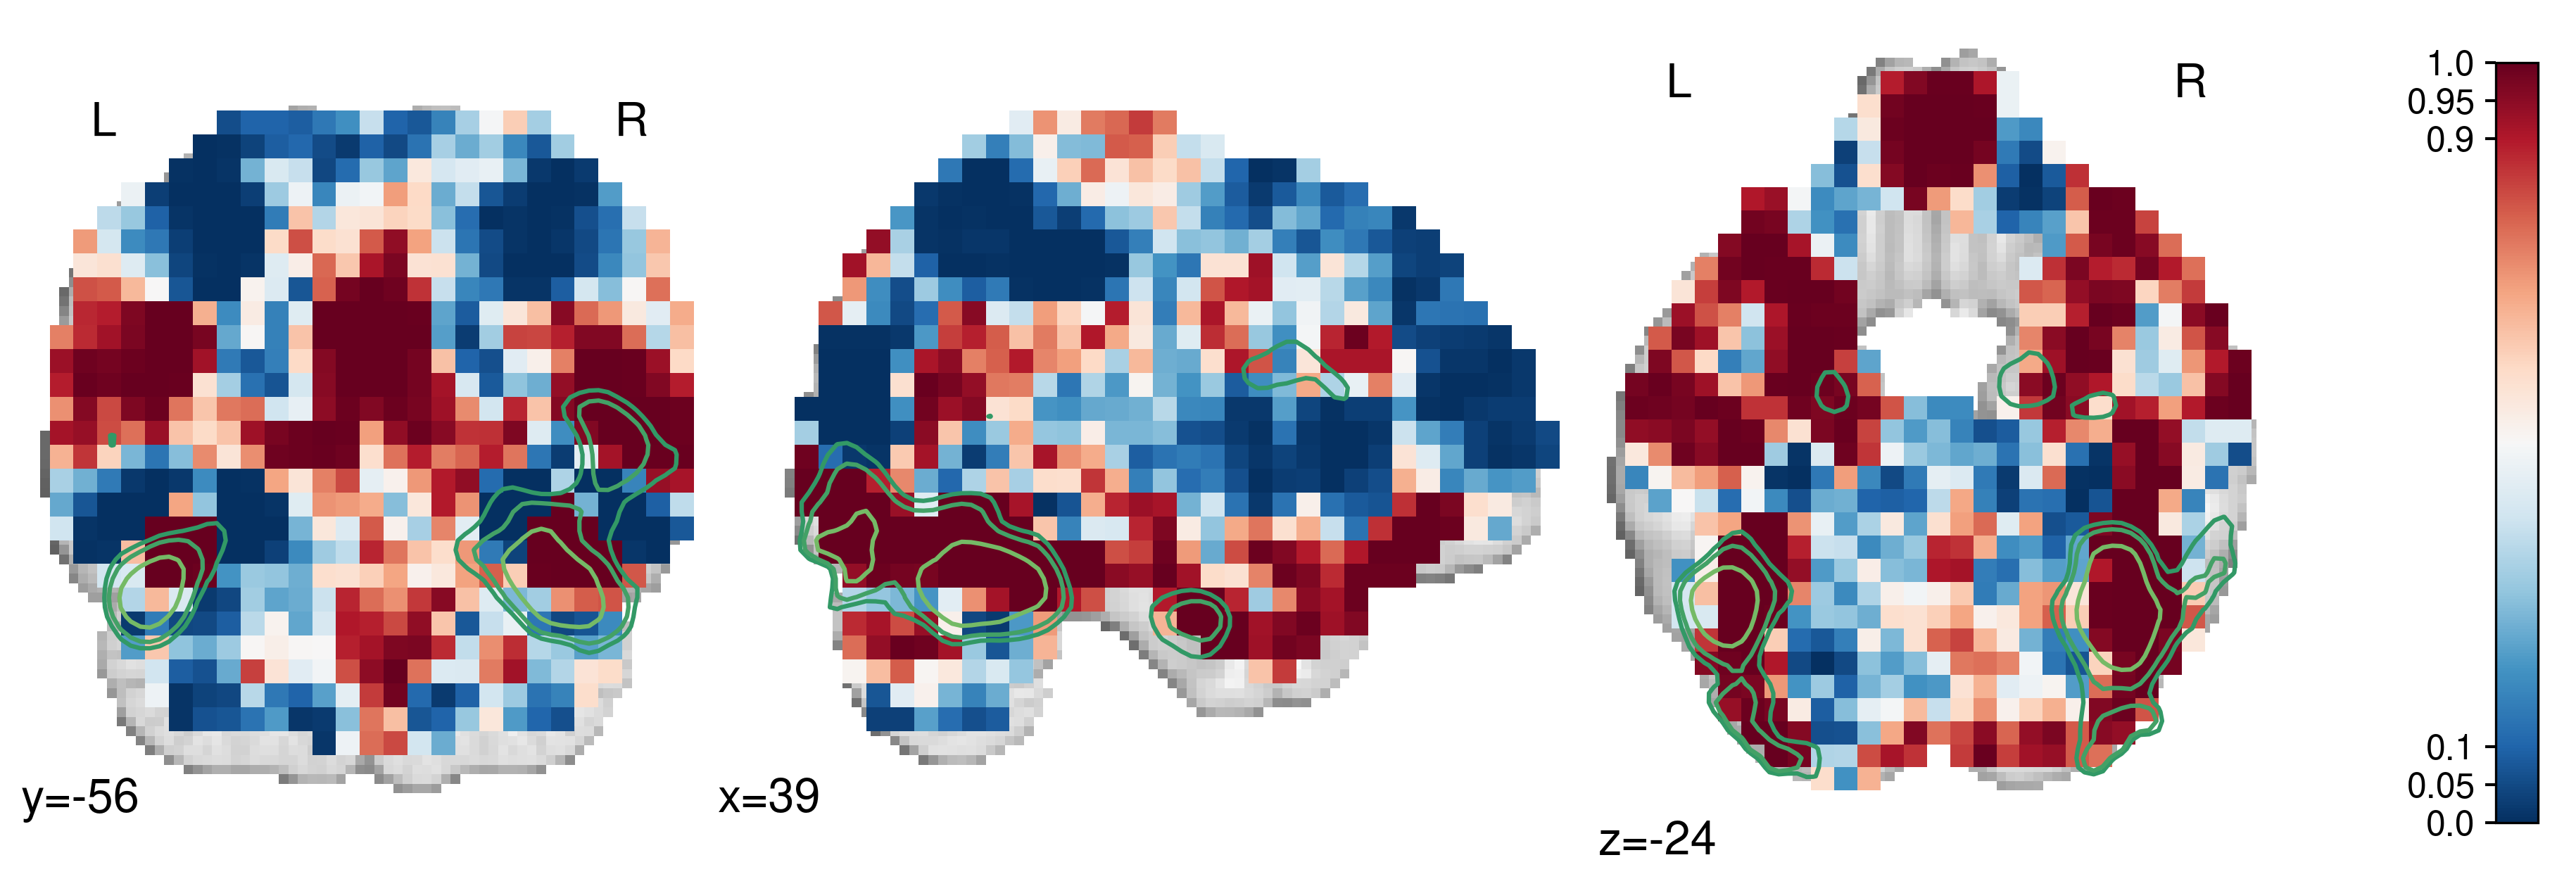

In [17]:
figure = plt.figure(figsize=(12, 4), dpi=300)
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Nimbus Sans"


display = plot_stat_map(
    posterior_map_image, 
    template_image,
    cut_coords=mni_coordinate,
    threshold=0,
    cmap="RdBu_r",
    draw_cross=False,
    black_bg=False,
    figure=figure,
)

display.add_contours(
    neuroquery_map_image, 
    levels=levels,
    cmap="summer"
)

# replicate Gang's colorbar
ticks = np.array([1, 0.95, 0.9, 0.1, 0.05, 0])
display._cbar.set_ticks(2 * ticks - 1)
display._cbar.set_ticklabels(ticks)
display._colorbar_ax.yaxis.set_tick_params(width=1)

display.annotate(size=16)

plt.savefig("posterior.pdf")